In [ ]:
!python --version

Python 3.11.12


# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Load Core Libraries

In [ ]:
import os
import zipfile
import tensorflow as tf #deep learning model
import numpy as np #Data wrangling
import pandas as pd #Data wrangling
from pyspark.sql import SparkSession, functions as F #Used to read large Parquet datasets

#Custom Layers for Deserialization
These are layers we defined during training, so we re-register them to load the saved model.
register_keras_serializable() is necessary to deserialize custom objects.

In [ ]:
# ---------------------
# 1️⃣ Reload your saved model
# ---------------------
@tf.keras.utils.register_keras_serializable()
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)

    def call(self, inputs):
        return inputs

In [ ]:
@tf.keras.utils.register_keras_serializable()
class SliceLayer(tf.keras.layers.Layer):
    def __init__(self, index, **kwargs):
        super(SliceLayer, self).__init__(**kwargs)
        self.index = index

    def call(self, inputs):
        return inputs[:, :, self.index]

In [ ]:
@tf.keras.utils.register_keras_serializable()
class SqueezeLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.squeeze(inputs, axis=-1)

#Custom Metric
Used for model evaluation during training — must be passed again for loading

In [ ]:
@tf.keras.utils.register_keras_serializable()
def r2_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())


#Load the Trained Model

In [ ]:
# Load model
model = tf.keras.models.load_model(
    "/content/drive/MyDrive/XAI/final_transformer_model.keras",
    custom_objects={
        'r2_score': r2_score,
        'PositionalEncoding': PositionalEncoding,
        'SliceLayer': SliceLayer,
        'SqueezeLayer': SqueezeLayer
    }
)

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 12, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_layer         │ (None, 12)        │          0 │ input_layer[0][0] │
│ (SliceLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_layer_1       │ (None, 12)        │          0 │ input_layer[0][0] │
│ (SliceLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_layer_2       │ (None, 12)        │          0 │ input_layer[0][0] │
│ (SliceLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_layer_3       │ (None, 12)        │          0 │ input_layer[0][0] │
│ (SliceLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 12, 8)     │        800 │ slice_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 12, 8)     │        800 │ slice_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 12, 8)     │        800 │ slice_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 12, 8)     │        800 │ slice_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 12, 32)    │          0 │ embedding[0][0],  │
│ (Concatenate)       │                   │            │ embedding_1[0][0… │
│                     │                   │            │ embedding_2[0][0… │
│                     │                   │            │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 12, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 12, 38)    │          0 │ concatenate[0][0… │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 12, 64)    │      2,496 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 12, 64)    │          0 │ dense[0][0]       │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 12, 64)    │     66,368 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 12, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 12, 64)    │          0 │ positional_encod

 Total params: 516,485 (1.97 MB)

 Trainable params: 172,161 (672.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 344,324 (1.31 MB)

#Load the Parquet dataset

In [ ]:
# ---------------------
# 2️⃣ Reload your Parquet data
# ---------------------

zip_file_path = '/content/drive/MyDrive/preprocessingForSingleTimeSeries/sequenced_for_single_model.zip'
extract_path = '/content/extracted_data'

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

spark = SparkSession.builder \
    .appName("GHGEmissionsForecasting") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .getOrCreate()

In [ ]:
full_df = spark.read.parquet(extract_path)

#Select One Test Sample
1.   Loops through Spark rows
2.   Extracts the 12-timestep sequence for each row
3.   Splits categorical vs numerical features
4.   Returns them as NumPy arrays

In [ ]:
# ---------------------
# 3️⃣ Prepare one batch from the test set
# ---------------------

sequence_length = 12
categorical_index_cols = ["iso3_country_index", "sector_index", "subsector_index", "gas_index"]
numerical_feature_columns = ["lat_scaled", "lon_scaled", "duration_scaled", "start_year_scaled", "start_month_sin", "start_month_cos"]

def extract_batch(df, n_samples=1):
    cat_seqs = []
    num_seqs = []
    target_seqs = []


    rows = df.limit(n_samples).collect()

    #loop through the rows
    for row in rows:
        cat_seq = []
        num_seq = []

        #Extract the 12-months timestep in each row and divide it into num and categorical features
        for timestep in row["feature_sequence"]:
            cat_features = np.array([
                timestep["iso3_country_index"],
                timestep["sector_index"],
                timestep["subsector_index"],
                timestep["gas_index"]
            ], dtype=np.int32)

            num_features = np.array([
                timestep["lat_scaled"],
                timestep["lon_scaled"],
                timestep["duration_scaled"],
                timestep["start_year_scaled"],
                timestep["start_month_sin"],
                timestep["start_month_cos"]
            ], dtype=np.float32)

            cat_seq.append(cat_features)
            num_seq.append(num_features)

        cat_seqs.append(np.array(cat_seq))
        num_seqs.append(np.array(num_seq))
        target_seqs.append(np.array(row["target_sequence"]))

    return np.array(cat_seqs), np.array(num_seqs), np.array(target_seqs)

Filter the most recent year for test sampling

In [ ]:
# Get the latest year for testing
test_year = full_df.select("start_year").distinct().orderBy("start_year", ascending=False).collect()[0]['start_year']
test_df = full_df.filter(F.col("start_year") == test_year)

#Grabs just 1 sample
cat_batch, num_batch, target_batch = extract_batch(test_df, n_samples=1)

print("Categorical input shape:", cat_batch.shape)
print("Numerical input shape:", num_batch.shape)
print("Target shape:", target_batch.shape)

Categorical input shape: (1, 12, 4)
Numerical input shape: (1, 12, 6)
Target shape: (1, 12)


#Verify Model

In [ ]:
# ---------------------
# 4️⃣ Verify predictions
# ---------------------

predictions = model.predict([cat_batch, num_batch])
print("Model predictions (log scale):", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Model predictions (log scale): [[ 0.25497672  3.7297933  -3.538685    3.6218998   0.9907275   2.3399324
  -0.37602323 -1.2595158   2.799337   -1.9483246   0.25497672 -1.3722259 ]]


#Baseline Input Defined
This sets the "neutral" baseline that Integrated Gradients will interpolate from. (All zeros = neutral signal.)

In [ ]:
import tensorflow as tf

# ---------------------
# 5️⃣ Define baseline input (all zeros for now)
# ---------------------

baseline_cat = tf.zeros_like(cat_batch)
baseline_num = tf.zeros_like(num_batch)

#Calculate Integrated Gradients

This function does the actual IG math:
1.   Linearly interpolates from baseline → actual input using alphas
2.   Computes gradients along the path
3.   Averages gradients
4.   Multiplies by (input - baseline)

It’s just the path integral approximation of attribution.


In [ ]:

# ---------------------
# 6️⃣ Integrated Gradients function
# ---------------------

def compute_integrated_gradients_num_only(model,cat_input,num_input,baseline_num,target_index=None,m_steps=50):

    # Step 1: Convert inputs to tensors
    # Categorical inputs remain constant
    cat_input_fixed = tf.convert_to_tensor(cat_input, dtype=tf.int32)

    # Expand dims to allow broadcasting
    expanded_num = tf.convert_to_tensor(num_input, dtype=tf.float32)
    baseline_num = tf.convert_to_tensor(baseline_num, dtype=tf.float32)

    # Step 2: Create alpha steps from 0 to 1
    #This defines the interpolation points from baseline → input.
    alphas = tf.linspace(0.0, 1.0, m_steps + 1)

    # Step 3: Interpolate input between baseline and actual input
    #interpolated_num = [baseline + α * (input - baseline) for α in alphas]
    interpolated_num = [baseline_num + alpha * (expanded_num - baseline_num) for alpha in alphas]
    interpolated_num = tf.concat(interpolated_num, axis=0)

    # Repeat categorical input for all alphas
    interpolated_cat = tf.repeat(cat_input_fixed, repeats=m_steps + 1, axis=0)

    #  Step 5: Use GradientTape to compute gradients
    # Compute gradients
    with tf.GradientTape() as tape:
        tape.watch(interpolated_num) # because you want grads w.r.t. this
        preds = model([interpolated_cat, interpolated_num])

        if target_index is not None:
            preds = preds[:, target_index]

    # Step 6: Compute gradients at each step
    grads = tape.gradient(preds, interpolated_num)

    # Step 7: Average gradients across the path
    avg_grads_num = tf.reduce_mean(grads, axis=0)

    # Step 8: Compute final attribution
    integrated_grads_num = (expanded_num - baseline_num) * avg_grads_num

    return integrated_grads_num.numpy()



In [ ]:
timestep = 0

ig_num = compute_integrated_gradients_num_only(
    model,
    cat_batch,
    num_batch,
    baseline_num,
    target_index=timestep,
    m_steps=50
)

print("Integrated Gradients - Numerical shape:", ig_num.shape)


Integrated Gradients - Numerical shape: (1, 12, 6)


In [ ]:
ig_num = ig_num[0]  # Remove batch dimension
print("Shape after squeezing:", ig_num.shape)

Shape after squeezing: (12, 6)


#Visualize Monthly Contributions

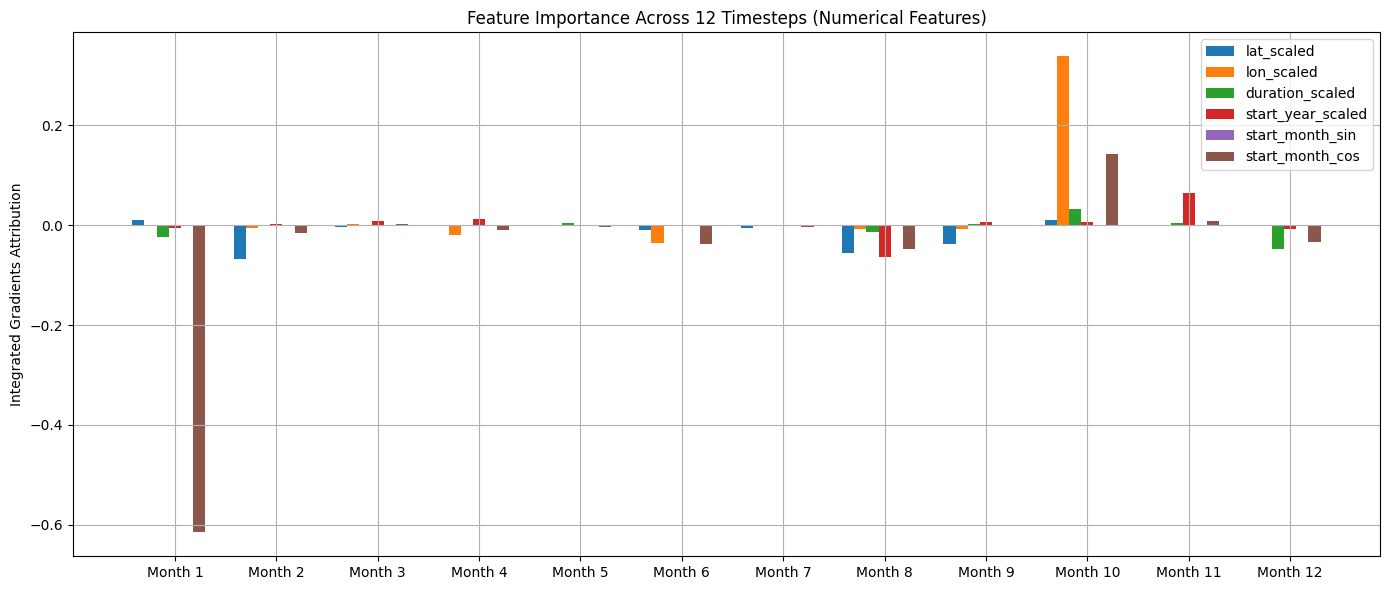

In [ ]:
import matplotlib.pyplot as plt

numerical_feature_columns = ["lat_scaled", "lon_scaled", "duration_scaled",
                             "start_year_scaled", "start_month_sin", "start_month_cos"]

if len(ig_num.shape) == 3:
    ig_num = ig_num[0]

plt.figure(figsize=(14, 6))

bar_width = 0.12  # Narrow bars for clarity

for feature_idx, feature_name in enumerate(numerical_feature_columns):
    positions = np.arange(12) + feature_idx * bar_width
    plt.bar(
        positions,
        ig_num[:, feature_idx],
        width=bar_width,
        label=feature_name
    )

plt.xticks(np.arange(12) + (len(numerical_feature_columns) / 2) * bar_width,
           [f"Month {t+1}" for t in range(12)])
plt.ylabel("Integrated Gradients Attribution")
plt.title("Feature Importance Across 12 Timesteps (Numerical Features)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


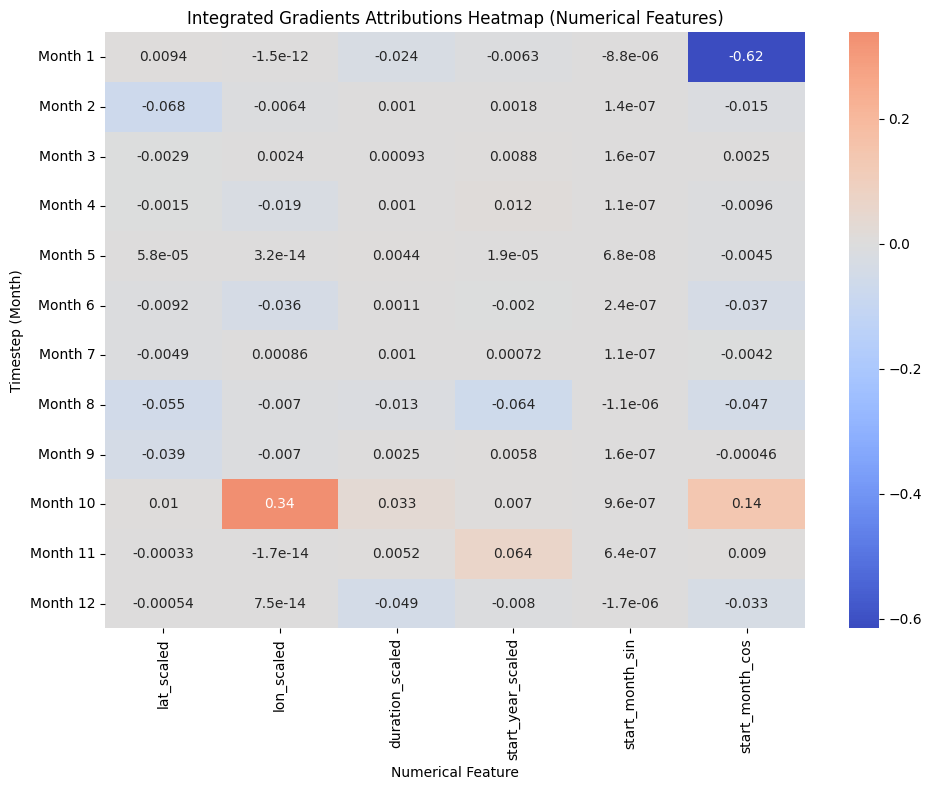

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Just to be safe, remove batch dim if still there
if len(ig_num.shape) == 3:
    ig_num = ig_num[0]

# Create a DataFrame for easier plotting
import pandas as pd

df = pd.DataFrame(
    ig_num,
    columns=numerical_feature_columns,
    index=[f"Month {i+1}" for i in range(12)]
)

plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, cmap="coolwarm", center=0)
plt.title("Integrated Gradients Attributions Heatmap (Numerical Features)")
plt.ylabel("Timestep (Month)")
plt.xlabel("Numerical Feature")
plt.tight_layout()
plt.show()


#Aggregated Yearly Attribution


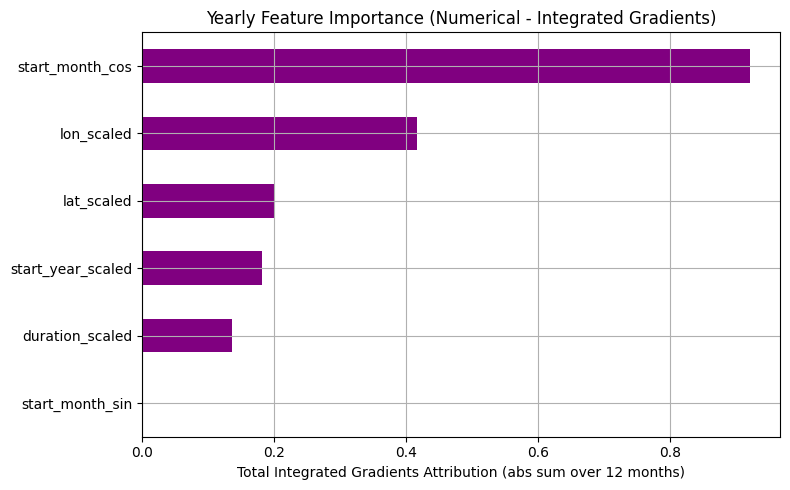

In [ ]:
# ---------------------
# 🔥 Yearly (aggregated) Integrated Gradients per feature
# ---------------------

# Sum absolute IG values across all months for each feature
yearly_ig = df.abs().sum(axis=0)

# Plot
plt.figure(figsize=(8, 5))
yearly_ig.sort_values().plot(kind='barh', color='purple')
plt.xlabel("Total Integrated Gradients Attribution (abs sum over 12 months)")
plt.title("Yearly Feature Importance (Numerical - Integrated Gradients)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# ---------------------
# Save yearly IG attributions to JSON
# ---------------------

yearly_ig_dict = yearly_ig.to_dict()

output_path = "/content/drive/MyDrive/XAI/yearly_ig.json"

import json
with open(output_path, "w") as f:
    json.dump(yearly_ig_dict, f, indent=4)

print(f"✅ Yearly IG attributions saved to {output_path}")

✅ Yearly IG attributions saved to /content/drive/MyDrive/XAI/yearly_ig.json
